# Program Creator

> Determinstic program creator from a visual observation.

In [ ]:
#| default_exp models.program.creator

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore import *
from fastcore.utils import *

In [ ]:
#| hide
from mawm.data.loaders import RolloutObservationDataset

# | hide
from torchvision import transforms
import numpy as np

ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE =\
    3, 32, 256, 32, 40


import torch
from torchvision.transforms import v2


void_tf = transforms.Lambda(lambda x: x)
dataset = RolloutObservationDataset(
    agent='agent_0',
    root='../datasets/marl_grid_data/',
    transform=void_tf,
    buffer_size=10,
    train=True
)
dataset.load_next_buffer()

Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
#| export
import cv2
import numpy as np
def get_graphics_primitives(img_np):
    img = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    pixels = img.reshape(-1, 3)
    colors = np.unique(pixels, axis=0)

    primitives = []
    background_color = np.array([0, 0, 0])  # assuming black background
    for color in colors:
        if np.all(color == background_color):
            continue

        mask = cv2.inRange(img, color, color)
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            primitives.append((color, x, y, w, h))
            
    return primitives
    


In [ ]:
#| hide
import numpy as np
indx = np.random.randint(0, len(dataset))
obs = dataset[indx][0]
inp = cv2.cvtColor(obs, cv2.COLOR_BGR2RGB)
primitives = get_graphics_primitives(inp)
primitives

[(array([28,  0,  0], dtype=uint8), 22, 22, 1, 1),
 (array([28,  0,  0], dtype=uint8), 19, 22, 1, 1),
 (array([28,  0,  0], dtype=uint8), 22, 19, 1, 1),
 (array([28,  0,  0], dtype=uint8), 19, 19, 1, 1),
 (array([74, 65, 42], dtype=uint8), 12, 36, 6, 6),
 (array([74, 65, 42], dtype=uint8), 0, 30, 6, 6),
 (array([74, 65, 42], dtype=uint8), 30, 18, 6, 6),
 (array([74, 65, 42], dtype=uint8), 0, 6, 42, 12),
 (array([198,   0,   0], dtype=uint8), 19, 19, 4, 4),
 (array([255,   0,   0], dtype=uint8), 20, 20, 2, 2)]

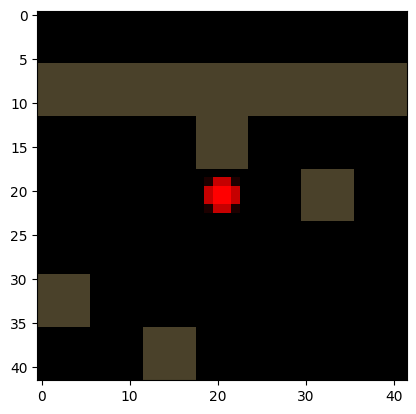

In [ ]:
#| hide
import matplotlib.pyplot as plt
plt.imshow(obs)
plt.show()

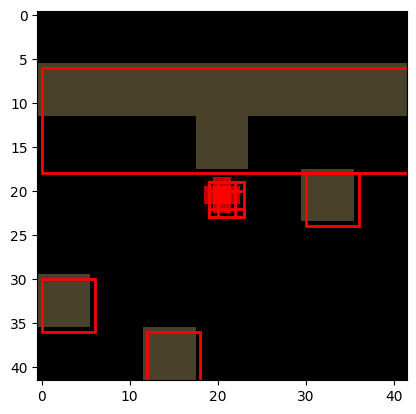

In [ ]:
#| hide
#draw bounding boxes to the location of the primitives
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
ax.imshow(obs)
for primitive in primitives:
    color, x1, y1, w, h = primitive
    x2, y2 = x1 + w, y1 + h
    
    # Draw rectangle
    ax.add_patch(plt.Rectangle((x1, y1), w, h, edgecolor='r', facecolor='none', linewidth=2))
    rgb_color = (color[2]/255, color[1]/255, color[0]/255)
    # ax.plot((x1, x2), (y1, y2), '-r', linewidth=2)
    

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

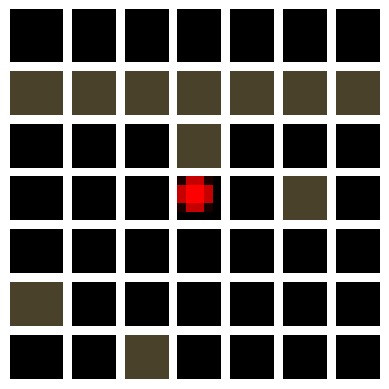

In [ ]:
#| export
import cv2
import matplotlib.pyplot as plt
def show_grid(img, GRID = 7, CELL = 6):
    if not CELL:
        CELL = img.shape[0] // GRID
    
    vis = img.copy()
    vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    for i in range(1, GRID):
        cv2.line(vis, (i*CELL, 0), (i*CELL, 42), (255,255,255), 1)
        cv2.line(vis, (0, i*CELL), (42, i*CELL), (255,255,255), 1)
    plt.imshow(vis, interpolation="nearest")
    plt.axis("off")

    return vis
# show_grid(inp)

In [ ]:
#| export

def get_cell_color(cell):
    np_to_tuple = lambda arr: tuple(int(x) for x in arr)
    pixels = cell.reshape(-1, 3)
    colors, counts = np.unique(pixels, axis=0, return_counts=True)
    # print(colors, len(colors), "+++++")
    # color = colors[np.argmax(counts)]
    if len(colors) == 1:
        if np_to_tuple(colors[0]) in [(0, 255, 0)]:
            return "G" #"Goal"
        elif np_to_tuple(colors[0]) in [(74, 65, 42)]:
            return "W" #"Wall"
        else:
            return "E" #"Empty"
        
    else:
        
        for color in colors:
            if np_to_tuple(color) in [(198, 0, 0), (28, 0, 0), (255, 0, 0)]:
                color = (255, 0, 0)
                return "R" #"RedAgent"
            elif np_to_tuple(color) in [(0, 0, 198), (0, 0, 255)]:
                color = (0, 0, 255)
                return "B" #"BlueAgent"
                
    

In [ ]:
# | export
def get_grid_chars(img, GRID=7, CELL=6): #cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cells = [[img[j*CELL:(j+1)*CELL, i*CELL:(i+1)*CELL]
              for i in range(GRID)]
              for j in range(GRID)
            ]
    
    grid = np.zeros((GRID,GRID), dtype=object)
    for r in range(GRID):
        for c in range(GRID):
            color = get_cell_color(cells[r][c])
            grid[r][c] = color
    return grid

In [ ]:
# | hide
# grid = get_grid_chars(inp)
# grid

array([['E', 'E', 'E', 'E', 'E', 'E', 'E'],
       ['W', 'W', 'W', 'W', 'W', 'W', 'W'],
       ['E', 'E', 'E', 'W', 'E', 'E', 'E'],
       ['E', 'E', 'E', 'R', 'E', 'W', 'E'],
       ['E', 'E', 'E', 'E', 'E', 'E', 'E'],
       ['W', 'E', 'E', 'E', 'E', 'E', 'E'],
       ['E', 'E', 'W', 'E', 'E', 'E', 'E']], dtype=object)

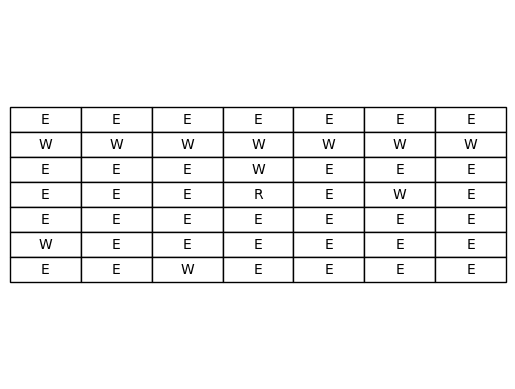

In [ ]:
# #| hide
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# ax.axis('tight')
# ax.axis('off')
# table = ax.table(cellText=grid, loc='center', cellLoc='center')
# table.scale(1, 1.5)
# plt.show()

In [ ]:
# #| hide
# # get indices of walls in the grid
# wall_indices = np.argwhere(grid == "W")
# wall_indices

array([[1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 6],
       [2, 3],
       [3, 5],
       [5, 0],
       [6, 2]])

In [ ]:
# grid[wall_indices[0][0], wall_indices[0][1]]

array([['W', 'W', 'W', 'W', 'W', 'W', 'W'],
       ['E', 'E', 'E', 'E', 'E', 'E', 'E']], dtype=object)

In [ ]:
# #| hide
# wall_indices = np.argwhere(grid == "W")
# empty_indices = np.argwhere(grid == "E")
# red_agent_indices = np.argwhere(grid == "R")
# blue_agent_indices = np.argwhere(grid == "B")
# goal_indices = np.argwhere(grid == "G")

In [ ]:
# #| hide
# from mawm.core import Program, PRIMITIVE_TEMPLATES, PRIM_NAME_TO_IDX

In [ ]:
# #| hide
# [("CellObstacle", idx[0], idx[1]) for idx in wall_indices]

[('CellObstacle', 1, 0),
 ('CellObstacle', 1, 1),
 ('CellObstacle', 1, 2),
 ('CellObstacle', 1, 3),
 ('CellObstacle', 1, 4),
 ('CellObstacle', 1, 5),
 ('CellObstacle', 1, 6),
 ('CellObstacle', 2, 3),
 ('CellObstacle', 3, 5),
 ('CellObstacle', 5, 0),
 ('CellObstacle', 6, 2)]

In [ ]:
# wall_tokens  =[("CellObstacle", idx[0], idx[1]) for idx in wall_indices]

In [ ]:
# PRIM_NAME_TO_IDX

{'CellEmpty': 0,
 'CellObstacle': 1,
 'CellItem': 2,
 'CellGoal': 3,
 'CellAgent': 4,
 'GoalAt': 5,
 'ItemAt': 6,
 'Near': 7,
 'SeeGoal': 8,
 'CanMove': 9,
 'OtherAgentAt': 10,
 'OtherAgentNear': 11,
 'OtherAgentDirection': 12}

In [ ]:
# #| hide
# wall_prims = [(PRIM_NAME_TO_IDX[prim], [x, y]) for (prim, x, y) in wall_tokens]

In [ ]:
# wall_prims

[(1, [1, 0]),
 (1, [1, 1]),
 (1, [1, 2]),
 (1, [1, 3]),
 (1, [1, 4]),
 (1, [1, 5]),
 (1, [1, 6]),
 (1, [2, 3]),
 (1, [3, 5]),
 (1, [5, 0]),
 (1, [6, 2])]

In [ ]:
# #| hide
# empty_prims  =[("CellEmpty", idx[0], idx[1]) for idx in empty_indices]

In [ ]:
# #| hide
# empty_tokens = [(PRIM_NAME_TO_IDX[prim], [x, y]) for (prim, x, y) in empty_prims]

In [ ]:
# #| hide
# empty_tokens

[(0, [0, 0]),
 (0, [0, 1]),
 (0, [0, 2]),
 (0, [0, 3]),
 (0, [0, 4]),
 (0, [0, 5]),
 (0, [0, 6]),
 (0, [2, 0]),
 (0, [2, 1]),
 (0, [2, 2]),
 (0, [2, 4]),
 (0, [2, 5]),
 (0, [2, 6]),
 (0, [3, 0]),
 (0, [3, 1]),
 (0, [3, 2]),
 (0, [3, 4]),
 (0, [3, 6]),
 (0, [4, 0]),
 (0, [4, 1]),
 (0, [4, 2]),
 (0, [4, 3]),
 (0, [4, 4]),
 (0, [4, 5]),
 (0, [4, 6]),
 (0, [5, 1]),
 (0, [5, 2]),
 (0, [5, 3]),
 (0, [5, 4]),
 (0, [5, 5]),
 (0, [5, 6]),
 (0, [6, 0]),
 (0, [6, 1]),
 (0, [6, 3]),
 (0, [6, 4]),
 (0, [6, 5]),
 (0, [6, 6])]

In [ ]:
# program_tokens = wall_prims + empty_tokens
# program = Program(tokens=program_tokens)

In [ ]:
# program

CellObstacle(1, 0) | CellObstacle(1, 1) | CellObstacle(1, 2) | CellObstacle(1, 3) | CellObstacle(1, 4) | CellObstacle(1, 5) | CellObstacle(1, 6) | CellObstacle(2, 3) | CellObstacle(3, 5) | CellObstacle(5, 0) | CellObstacle(6, 2) | CellEmpty(0, 0) | CellEmpty(0, 1) | CellEmpty(0, 2) | CellEmpty(0, 3) | CellEmpty(0, 4) | CellEmpty(0, 5) | CellEmpty(0, 6) | CellEmpty(2, 0) | CellEmpty(2, 1) | CellEmpty(2, 2) | CellEmpty(2, 4) | CellEmpty(2, 5) | CellEmpty(2, 6) | CellEmpty(3, 0) | CellEmpty(3, 1) | CellEmpty(3, 2) | CellEmpty(3, 4) | CellEmpty(3, 6) | CellEmpty(4, 0) | CellEmpty(4, 1) | CellEmpty(4, 2) | CellEmpty(4, 3) | CellEmpty(4, 4) | CellEmpty(4, 5) | CellEmpty(4, 6) | CellEmpty(5, 1) | CellEmpty(5, 2) | CellEmpty(5, 3) | CellEmpty(5, 4) | CellEmpty(5, 5) | CellEmpty(5, 6) | CellEmpty(6, 0) | CellEmpty(6, 1) | CellEmpty(6, 3) | CellEmpty(6, 4) | CellEmpty(6, 5) | CellEmpty(6, 6)

In [ ]:
#| export
from mawm.core import *
def create_specs_from_image(
    img_np,
    GRID=7,
    CELL=6
):
    grid = get_grid_chars(img_np, GRID=GRID, CELL=CELL)
    
    wall_indices = np.argwhere(grid == "W")
    empty_indices = np.argwhere(grid == "E")
    goal_index = np.argwhere(grid == "G")
    blueagent_index = np.argwhere(grid == "B")
    redagent_index = np.argwhere(grid == "R")
    
    wall_prims  =[("CellObstacle", idx[0], idx[1]) for idx in wall_indices]
    wall_tokens = [(PRIM_NAME_TO_IDX[prim], [x, y]) for (prim, x, y) in wall_prims]
    
    empty_prims  =[("CellEmpty", idx[0], idx[1]) for idx in empty_indices]
    empty_tokens = [(PRIM_NAME_TO_IDX[prim], [x, y]) for (prim, x, y) in empty_prims]

    goal_index = (goal_index[0][0], goal_index[0][1]) if len(goal_index) > 0 else None
    blueagent_index = (blueagent_index[0][0], blueagent_index[0][1]) if len(blueagent_index) > 0 else None
    redagent_index = (redagent_index[0][0], redagent_index[0][1]) if len(redagent_index) > 0 else None

    program_tokens = wall_tokens + empty_tokens
    if goal_index:
        program_tokens += [(PRIM_NAME_TO_IDX["CellGoal"], [goal_index[0], goal_index[1]])]
        # program_tokens += [(PRIM_NAME_TO_IDX["SeeGoal"])]

    if blueagent_index:
        program_tokens += [(PRIM_NAME_TO_IDX["CellAgent"], [blueagent_index[0], blueagent_index[1]])]

    if redagent_index:
        program_tokens += [(PRIM_NAME_TO_IDX["CellAgent"], [redagent_index[0], redagent_index[1]])]

    program = Program(tokens=program_tokens)
    
    return program

In [ ]:
#| export
# program = create_specs_from_image(inp)

In [ ]:
# program

CellObstacle(1, 0) | CellObstacle(1, 1) | CellObstacle(1, 2) | CellObstacle(1, 3) | CellObstacle(1, 4) | CellObstacle(1, 5) | CellObstacle(1, 6) | CellObstacle(2, 3) | CellObstacle(3, 5) | CellObstacle(5, 0) | CellObstacle(6, 2) | CellEmpty(0, 0) | CellEmpty(0, 1) | CellEmpty(0, 2) | CellEmpty(0, 3) | CellEmpty(0, 4) | CellEmpty(0, 5) | CellEmpty(0, 6) | CellEmpty(2, 0) | CellEmpty(2, 1) | CellEmpty(2, 2) | CellEmpty(2, 4) | CellEmpty(2, 5) | CellEmpty(2, 6) | CellEmpty(3, 0) | CellEmpty(3, 1) | CellEmpty(3, 2) | CellEmpty(3, 4) | CellEmpty(3, 6) | CellEmpty(4, 0) | CellEmpty(4, 1) | CellEmpty(4, 2) | CellEmpty(4, 3) | CellEmpty(4, 4) | CellEmpty(4, 5) | CellEmpty(4, 6) | CellEmpty(5, 1) | CellEmpty(5, 2) | CellEmpty(5, 3) | CellEmpty(5, 4) | CellEmpty(5, 5) | CellEmpty(5, 6) | CellEmpty(6, 0) | CellEmpty(6, 1) | CellEmpty(6, 3) | CellEmpty(6, 4) | CellEmpty(6, 5) | CellEmpty(6, 6) | CellAgent(3, 3)

In [ ]:
# len(program)

49

In [ ]:
#| export
SEQ_LEN = 49
PAD_PRIM = len(PRIMITIVE_TEMPLATES)  # index for padding primitive
PAD_PARAM = -1  # value for padding parameters
MAX_PARAMS = 2  # maximum number of parameters per primitive
import torch
def program_to_indices(program):
    tokens = program.tokens[:SEQ_LEN]

    prims = [t[0] for t in tokens]
    params = [list(t[1])[:MAX_PARAMS] for t in tokens]

    # pad params
    for p in params:
        while len(p) < MAX_PARAMS:
            p.append(PAD_PARAM)

    # pad program length
    pad_len = SEQ_LEN - len(tokens)
    prims += [PAD_PRIM] * pad_len
    params += [[PAD_PARAM]*MAX_PARAMS for _ in range(pad_len)]

    return (
        torch.tensor(prims).unsqueeze(0),
        torch.tensor(params).unsqueeze(0)
    )

In [ ]:
#| export
def batchify_programs(programs, seq_len=SEQ_LEN, max_params=MAX_PARAMS):
    prim_list = []
    param_list = []

    for p in programs:
        prim_ids, param_ids = program_to_indices(p)
        prim_list.append(prim_ids[0])       # (SEQ_LEN)
        param_list.append(param_ids[0])     # (SEQ_LEN, max_params)

    prim_batch = torch.stack(prim_list, dim=0)      # (B, SEQ_LEN)
    param_batch = torch.stack(param_list, dim=0)    # (B, SEQ_LEN, max_params)

    return prim_batch, param_batch


In [ ]:
#| hide
# batch_prim_ids, batch_param_tensor = batchify_programs([program, program])

In [ ]:
# batch_prim_ids.shape, batch_param_tensor.shape

(torch.Size([2, 49]), torch.Size([2, 49, 2]))

In [ ]:
#| hide
from mawm.models.program_embedder import ProgramEmbedder, PRIMITIVE_TEMPLATES
from mawm.models.program_encoder import ProgramEncoder
from mawm.core import *
from mawm.models.program_synthizer import Proposer
import torch
z = torch.randn(1, 32)
device = 'cpu'
grid_size= 7

num_primitives = len(PRIMITIVE_TEMPLATES)
p_embed = ProgramEmbedder(
    num_primitives= num_primitives,
    param_cardinalities= [7, 7],
    max_params_per_primitive= 2,
    d_name= 32,
    d_param= 32,
)

p_encoder = ProgramEncoder(num_primitives, [grid_size, grid_size],2, seq_len=49)


In [ ]:
#| hide
# out = p_encoder(batch_prim_ids, batch_param_tensor)

In [ ]:
# #| hide
# out.shape

torch.Size([2, 256])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()